In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import lightgbm as lgb
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [22]:
company = pd.read_csv('company_hierarchy.csv')
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [23]:
employee = pd.read_csv('employee.csv')
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [5]:
# merge employee and company information
data = pd.merge(left=employee, right=company, on='employee_id')
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


In [6]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
data.loc[data['dept'] == 'CEO', 'level'] = 'CEO'

for i in range(len(levels) - 1):
    boss_level = levels[i]
    empl_level = levels[i + 1]
    boss_id = data[data['level'] == boss_level]['employee_id']
    data.loc[data['boss_id'].isin(boss_id), 'level'] = empl_level

In [7]:
data[['employee_id', 'level']].sample(10)

,employee_id,level
6659,104922,IC
1457,6027,D
2281,153576,IC
2187,21046,IC
1983,142022,IC
8294,175928,IC
5561,123916,IC
1517,192369,MM
7181,63578,IC
1967,96981,IC


In [8]:
# value counts for each group
data['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

In [9]:
# find the managed employees for each employee
data['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = data[data['level'] == level]['boss_id']
    employee_ids = data[data['level'] == level]['employee_id']
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + data.loc[data['employee_id'] == e_id, 'counts'])
        b_counts = int(data.loc[data['employee_id'] == b_id, 'counts'])
        data.loc[data['employee_id'] == b_id, 'counts'] = e_counts + b_counts

In [11]:
data[['employee_id', 'level', 'counts']].sample(10)

,employee_id,level,counts
389,124893,D,58
6010,50166,IC,0
7525,57654,IC,0
9345,163389,IC,0
1802,80289,IC,0
6882,145312,IC,0
1662,175979,IC,0
7202,165864,IC,0
2003,65437,IC,0
3612,121233,D,45


In [12]:
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,counts
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


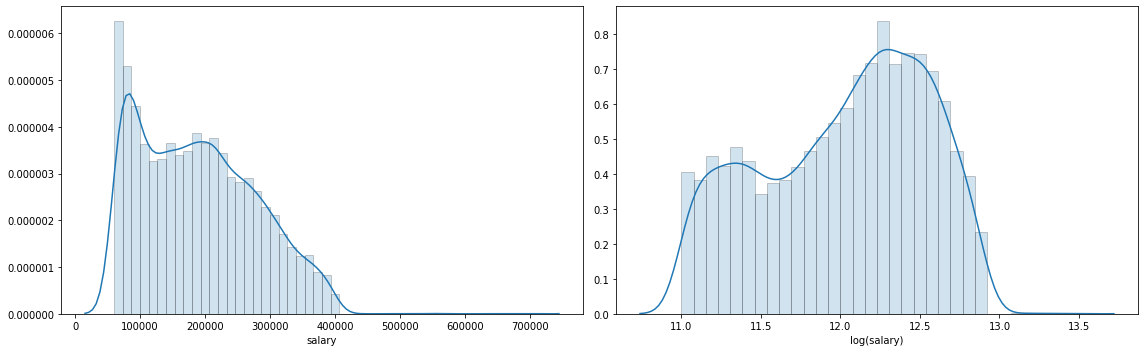

In [13]:
# Distribution of salary
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.distplot(data['salary'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(data['salary']), ax=ax[1], hist_kws=hist_kws)
ax[1].set_xlabel('log(salary)')
plt.tight_layout()
plt.show()

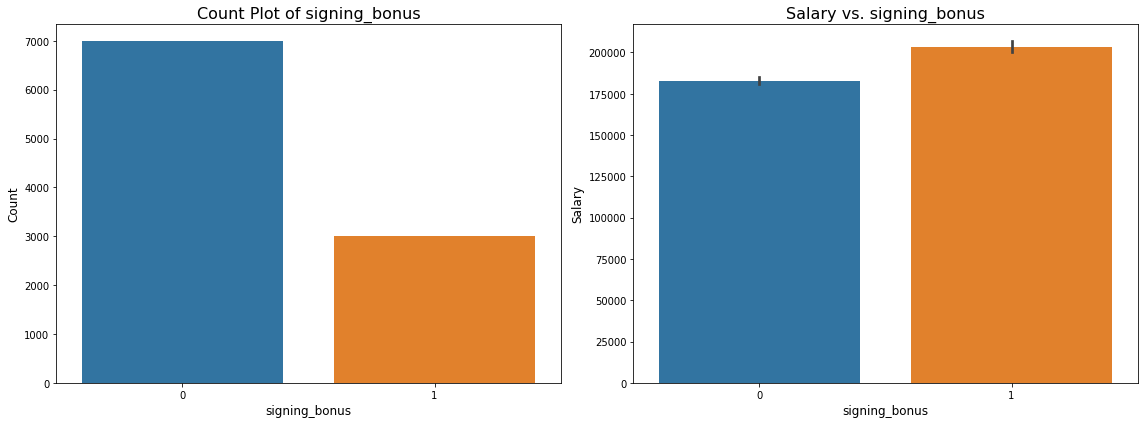

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='signing_bonus', data=data, ax=ax[0])
ax[0].set_xlabel('signing_bonus', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of signing_bonus', fontsize=16)

sns.barplot(x='signing_bonus', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('signing_bonus', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. signing_bonus', fontsize=16)
plt.tight_layout()
plt.show()

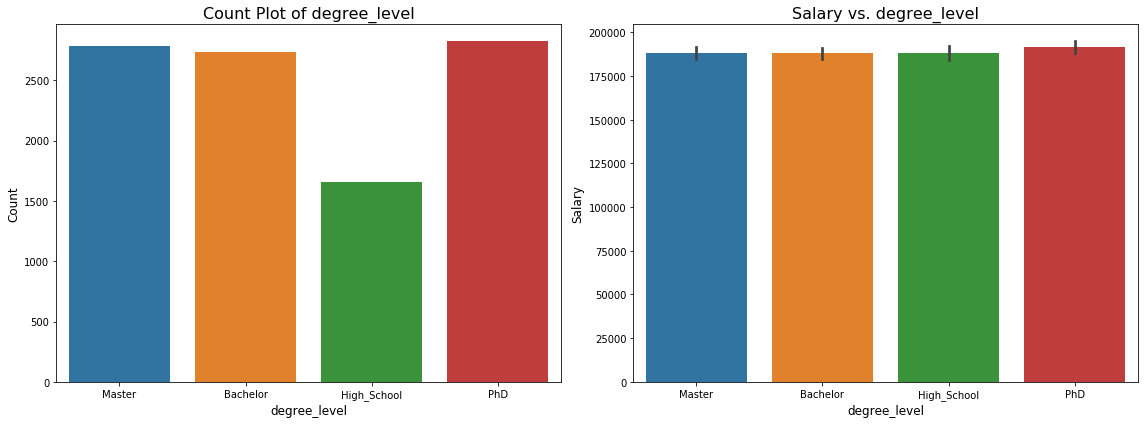

In [15]:
# visualization of 'degree_level'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='degree_level', data=data, ax=ax[0])
ax[0].set_xlabel('degree_level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of degree_level', fontsize=16)

sns.barplot(x='degree_level', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('degree_level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. degree_level', fontsize=16)
plt.tight_layout()
plt.show()

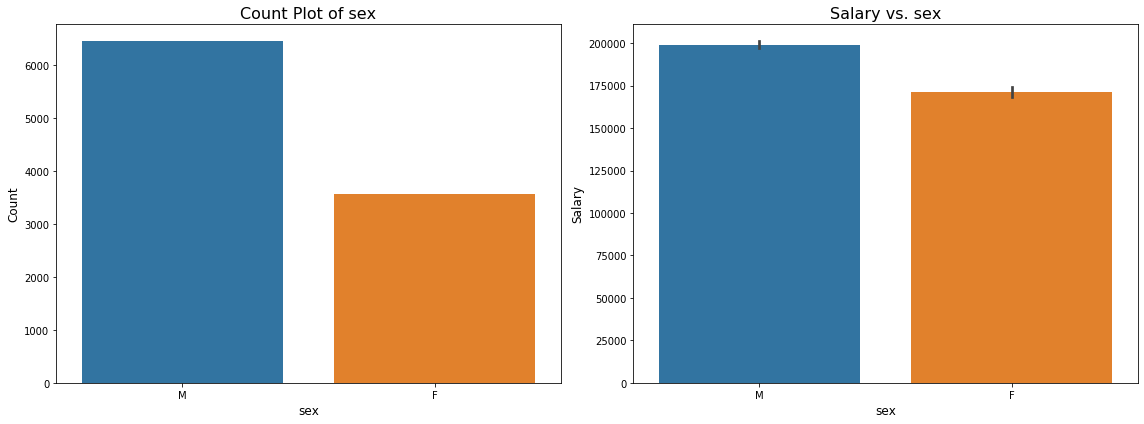

In [16]:
# visualization of 'sex'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='sex', data=data, ax=ax[0])
ax[0].set_xlabel('sex', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of sex', fontsize=16)

sns.barplot(x='sex', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('sex', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. sex', fontsize=16)
plt.tight_layout()
plt.show()

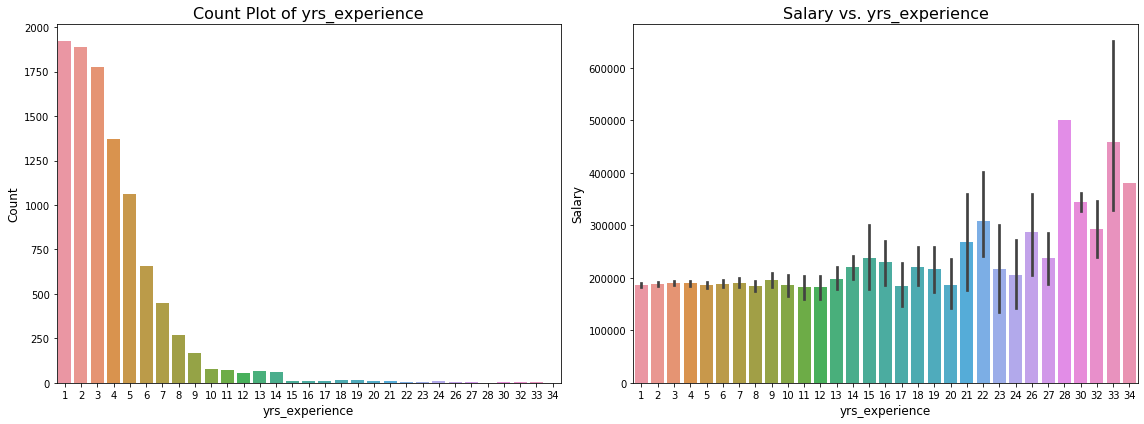

In [17]:
# visualization of 'yrs_experience'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='yrs_experience', data=data, ax=ax[0])
ax[0].set_xlabel('yrs_experience', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of yrs_experience', fontsize=16)

sns.barplot(x='yrs_experience', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('yrs_experience', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. yrs_experience', fontsize=16)
plt.tight_layout()
plt.show()

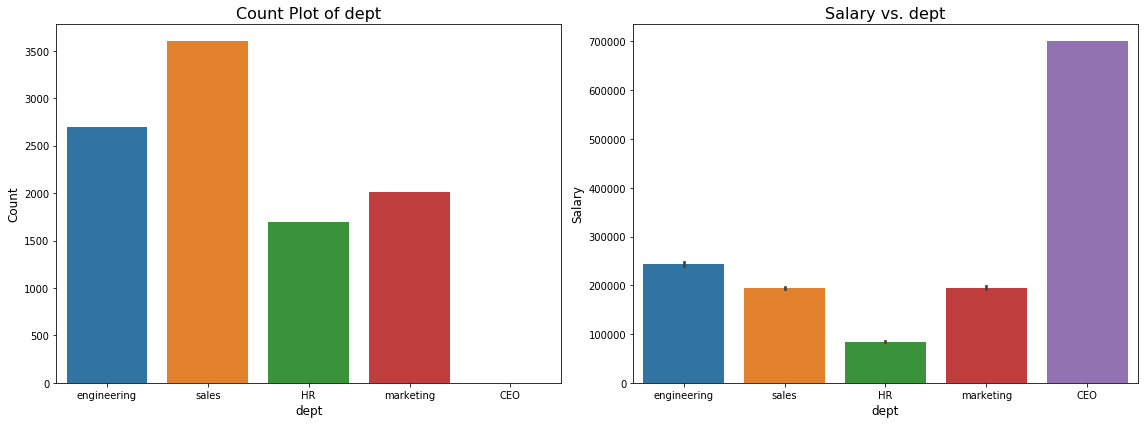

In [18]:
# visualization of 'dept'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dept', data=data, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dept', fontsize=16)

sns.barplot(x='dept', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. dept', fontsize=16)
plt.tight_layout()
plt.show()

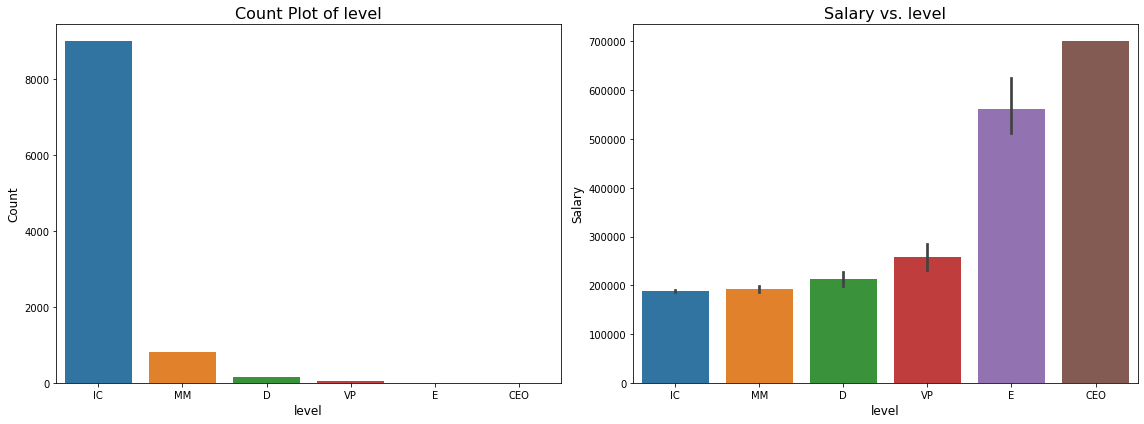

In [19]:
# visualization of 'signing_bonus'
orders = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='level', data=data, ax=ax[0], order=orders)
ax[0].set_xlabel('level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of level', fontsize=16)

sns.barplot(x='level', y='salary', data=data, ax=ax[1], order=orders)
ax[1].set_xlabel('level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. level', fontsize=16)
plt.tight_layout()
plt.show()

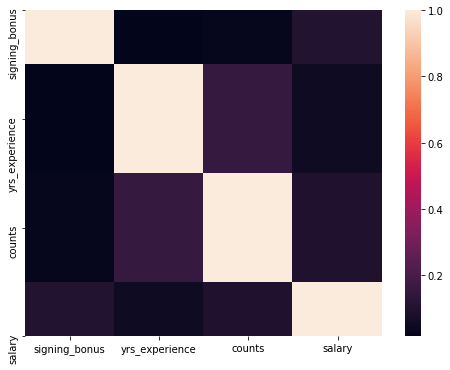

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
subset = data[['signing_bonus', 'yrs_experience', 'counts', 'salary']]
sns.heatmap(subset.corr(), ax=ax)
plt.show()

## Build Machine Learning Models with LightGBM

In [27]:
# Drop CEO department
data = data[data['dept'] != 'CEO']

# drop useless features
data = data.drop(labels=['employee_id', 'boss_id', 'level', 'counts'], axis=1)

data.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept
0,0,273000.0,Master,M,2,engineering
1,0,301000.0,Bachelor,F,1,sales
2,0,261000.0,Master,F,2,sales
3,0,86000.0,High_School,F,4,HR
4,0,126000.0,Bachelor,F,3,sales


In [28]:
# encoding categorical data
data['sex'] = (data['sex'] == 'M').astype(int)

degree_encoder = LabelEncoder()
data['degree_level'] = degree_encoder.fit_transform(data['degree_level'])

dept_encoder = LabelEncoder()
data['dept'] = dept_encoder.fit_transform(data['dept'])

In [29]:
# define categorical features
categorical_feature = ['signing_bonus', 'degree_level', 'sex', 'dept']
data[categorical_feature] = data[categorical_feature].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 6 columns):
signing_bonus     9999 non-null category
salary            9999 non-null float64
degree_level      9999 non-null category
sex               9999 non-null category
yrs_experience    9999 non-null int64
dept              9999 non-null category
dtypes: category(4), float64(1), int64(1)
memory usage: 274.0 KB


In [30]:
# split into training and test data set
X = data.drop('salary', axis=1)
y = data['salary']

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.25, random_state=42)

# transform into log scale
y_train = np.log(y_train)
y_test = np.log(y_test)

In [31]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False, 
                      categorical_feature=categorical_feature)

In [32]:
# Cross validation
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, stratified=False)

best_round = len(history['rmse-mean'])
print('Best rounds:\t', best_round)

/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't expl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best rounds:	 474


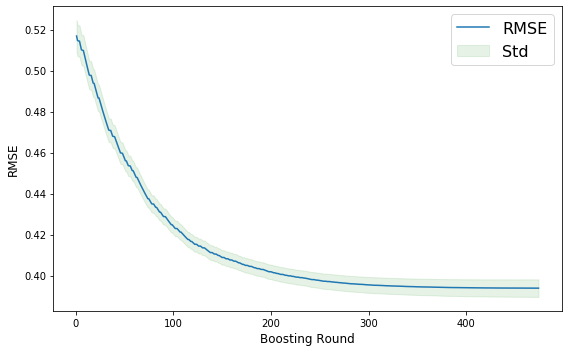

In [33]:
# visualization
rmse = np.array(history['rmse-mean'])
std = np.array(history['rmse-stdv'])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, best_round + 1), rmse, label='RMSE')
ax.fill_between(range(1, best_round + 1), rmse + std, rmse - std, 
                alpha=0.1, color='g', label='Std')
ax.set_xlabel('Boosting Round', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

In [34]:
# re-train the model and make predictions
clf = lgb.train(params, train_set=d_train, num_boost_round=best_round)
pred = clf.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 7499, number of used features: 5
[LightGBM] [Info] Start training from score 12.020859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [35]:
print('Test RMSE:\t', np.sqrt(mean_squared_error(y_test, pred)))
print('Test R2:\t', r2_score(y_test, pred))

Test RMSE:	 0.39080803975717354
Test R2:	 0.4020007295623995


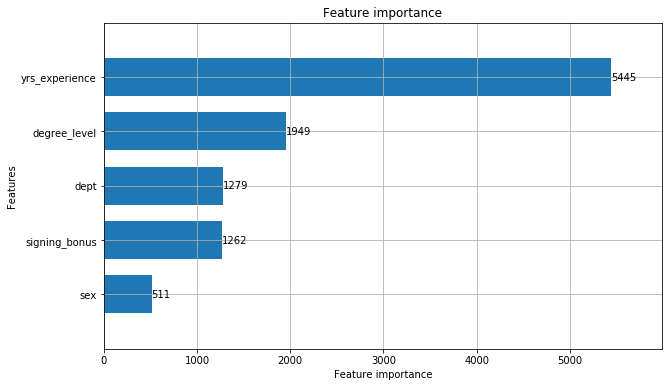

In [38]:
# feature importance
features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 6))
lgb.plot_importance(clf, ax=ax, height=0.7)
plt.show()


From above figure, we can see that years experience is the most influencial factor for employee's salary.

## Compare with Random Forest

In [61]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,12 mins 07 secs
H2O_cluster_timezone:,Europe/Amsterdam
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_opheliaming_sx234y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.539 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [62]:
data['log_salary'] = np.log(data['salary'])
data

,signing_bonus,salary,degree_level,sex,yrs_experience,dept,log_salary
0,0,273000.0,2,1,2,1,12.517227
1,0,301000.0,0,0,1,3,12.614866
2,0,261000.0,2,0,2,3,12.472276
3,0,86000.0,1,0,4,0,11.362103
4,0,126000.0,0,0,3,3,11.744037
...,...,...,...,...,...,...,...
9995,0,307000.0,0,1,4,1,12.634603
9996,0,302000.0,3,1,6,2,12.618182
9997,1,132000.0,0,1,4,3,11.790557
9998,0,77000.0,3,1,4,2,11.251561


In [63]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
for name in ['signing_bonus','sex', 'dept','degree_level']:
    h2o_df[name] = h2o_df[name].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [64]:
# Split into 80% training and 20% test dataset
train, test = h2o_df.split_frame(ratios = [0.8], seed = 1234)
feature = ['signing_bonus', 'degree_level', 'sex', 'dept','yrs_experience']
target = 'log_salary'

In [75]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1,  
                                 stopping_metric='rmse', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping metric is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |███████████████████████████████████████████████| 100%


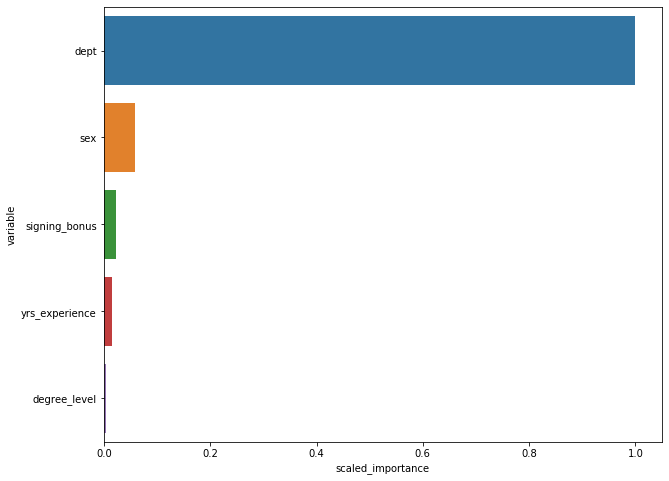

In [76]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [77]:
perf = model.model_performance(test)
perf


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.1732763841158416
RMSE: 0.4162648004766216
MAE: 0.34446338901947476
RMSLE: 0.03209985329833004
Mean Residual Deviance: 0.1732763841158416


My guess is that random forest is better for classification problem and GBM is better for regression problem.